In [1]:
############################################################################
#
#         Submitted for Quantum Algorithms Researcher Residency
#                         position at Agnostic.
#
#                Written by Dogan Sinar, dsinar@uwo.ca
#                        Fabruary 21, 2022
#
############################################################################
# 
#                  This program does the following:
#  
#   1. Creates a 2*2 binary data set.
#   2. Creates a seeded random array of 60 items, range[0, 1].
#   3. An 8 qubit device is defined, first two qubits are ancilla,
#      following 2 qubits are reference. These 4 qubits are
#      initialized in state ket0.
#   4. Following 4 qubits represent the data qubits, first two of these
#      qubits are 'trash qubits'. They are compared to reference
#      qubits through CSWAP operation. Data qubits are initialized
#      by basis embedding the binary data set.
#   5. From a Quantum Mechanical point of view, if reference and trash
#      qubits are in the same state, probability of measuring reference
#      state in ket0 must be 1. If they are not the same, probability of
#      measuring ket0 would be 0.5. Hence, optimization problem is such
#      that we have to minimize eqn: (1-expval(ancilla_qubit)), for each 
#      ancilla, after the CWAP operation.
#   6. COBYLA was used for local optimization and Basin Hopping was used
#      for global optimization. At the end of each optimization, trained
#      parameters for each data was recorded.
#   7. Trained parameters are used at the end of the program to compress
#      the entire data set. Associated ancilla qubit measurements are
#      given as an indicator of compression quality. Perfect compression
#      means each ancilla qubit probability is 1.
#
############################################################################
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
# Building the dataset and structuring it
mask = ((np.arange(2**4)[:,None] & (1 << np.arange(4))) != 0)
d_set = mask.astype(int).reshape(-1,2,2)
_1d_set = d_set.flatten()
np.random.seed(1984)
params = np.random.random(60, requires_grad=True)
data = [_1d_set[i:i+4] for i in range(0, len(_1d_set),4)]

In [3]:
def state_prep(data):   # Embeds desired classical information to the quantum circuit
    qml.BasisEmbedding(np.array([0, 0, 0, 0]), wires=[0, 1, 2, 3])
    qml.BasisEmbedding(data, wires=[4, 5, 6, 7])

In [4]:
# Lets build a circuit, This is where the magic happens.

dev_p = qml.device('default.qubit', wires=8, shots=None)    # Define the quantum device

@qml.qnode(dev_p)
def circuit(params, q):
    n_qubits = 8
    w_count = 4
    n = 0
    state_prep(q)

    while w_count < n_qubits:                                       # First layer of arbitrary rotations
        qml.Rot(params[n], params[n+1], params[n+2], wires=w_count)
        w_count += 1
        n += 3
    
    w_count = 4                                                     # First layer of controlled arbitrary rotations
    while w_count < n_qubits-1:
        qml.CRot(params[n], params[n+1], params[n+2], wires=(4,w_count+1))
        w_count += 1
        n += 3
                                                
    qml.CRot(params[n], params[n+1], params[n+2], wires=(5,4))      # Second layer of controlled arbitrary rotations
    n += 3
    qml.CRot(params[n], params[n+1], params[n+2], wires=(5,6))
    n += 3
    qml.CRot(params[n], params[n+1], params[n+2], wires=(5,7))
    n += 3

    qml.CRot(params[n], params[n+1], params[n+2], wires=(6,4))      # Third layer of controlled arbitrary rotations
    n += 3
    qml.CRot(params[n], params[n+1], params[n+2], wires=(6,5))
    n += 3
    qml.CRot(params[n], params[n+1], params[n+2], wires=(6,7))
    n += 3

    w_count = 4                                                     # Fourth layer of controlled arbitrary rotations
    while w_count < n_qubits-1:
        qml.CRot(params[n], params[n+1], params[n+2], wires=(7,w_count))
        w_count += 1
        n += 3

    w_count = 4
    while w_count < n_qubits:                                       # Second layer of arbitrary rotations
        qml.Rot(params[n], params[n+1], params[n+2], wires=w_count)
        w_count += 1
        n += 3
    

    qml.Hadamard(0)             # Ancilla qubit 1
    qml.CSWAP(wires=(0, 2, 4))
    qml.Hadamard(0)

    qml.Hadamard(1)             # Ancilla qubit 2
    qml.CSWAP(wires=(1, 3, 5))
    qml.Hadamard(1)


    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(6)), qml.expval(qml.PauliZ(7))
    


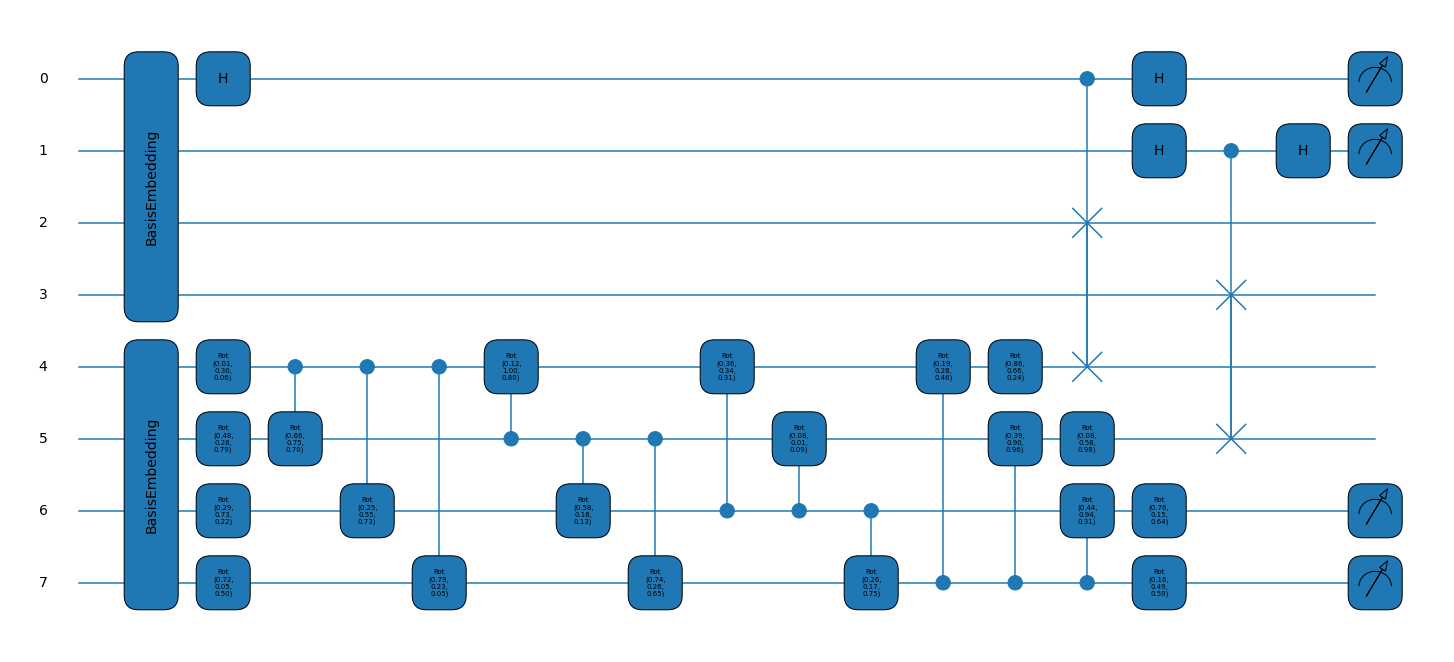

In [5]:
# Paramterized the circuit for visualization purposes
anci_0, anci_1, compressed_1, compressed_2 = circuit(params, data[0])
fig, ax = qml.draw_mpl(circuit, show_all_wires=True, decimals=2)(params, data[0])

In [40]:
def anci_dist(x,i):
    anci_0, anci_1, compressed_1, compressed_2 = circuit(x, data[i])
    return anci_0, anci_1

In [41]:
def fn_cost(x, i):      # Cost calculation is simple, in perfect compression we want: 1-expval(anci_0) = 1-expval(anci_1) = 0
    funx = 0
    steps = 0
    cost1, cost2 = anci_dist(x,i)
    funx += (1-cost1) + (1-cost2)
    cost_hist.append(funx)
    steps += 1
    print(funx)
    return funx

In [42]:
cost_hist = []
cost1_hist = []
weight_tensor = []

for i in range(len(data)):
    minimizer = {'method':'COBYLA', 'args':(i)}             # COBYLA was chosen for reduced cpu time. Results are more than satisfactory
    opti = sc.optimize.basinhopping(fn_cost, params, minimizer_kwargs=minimizer, niter=1)
    weight_tensor.append(opti.x)                            # Records trained parameters for the associated data point

0.3583763008032771
0.358376300803277
0.8276219277672321
0.3525372082769245
0.35253720827692414
0.7868262010733856
0.3535086528513516
0.3525372082769245
0.34494862437619667
0.3632321565879201
0.3449486243761962
0.3802558673648291
0.34499672685045535
0.37591801816654247
0.34344238908927904
0.35499579064266884
0.341612101483474
0.34951559391680775
0.32227172001608007
0.32437519852682994
0.3186655523134009
0.3214623700328383
0.3086864516046228
0.2995379229485574
0.28307405929202056
0.2933920620878381
0.2793167009305416
0.30042386603817084
0.2688328206911187
0.2685037148721796
0.2490211146226219
0.2401445031024535
0.42521571587199314
0.21114216492418603
0.24327439315626087
0.41729157349716095
0.2423360037674428
0.20778172714406906
0.25666007528260637
0.20778172714406773
0.20984580240892936
0.20807576876183065
0.20801675104922024
0.20522209472338904
0.20481067092314442
0.20467141340804484
0.20467141340804473
0.20467141340804484
0.20467141340804473
0.21663510154594567
0.6063989461801865
0.204

Text(0.5, 0, '# of Steps')

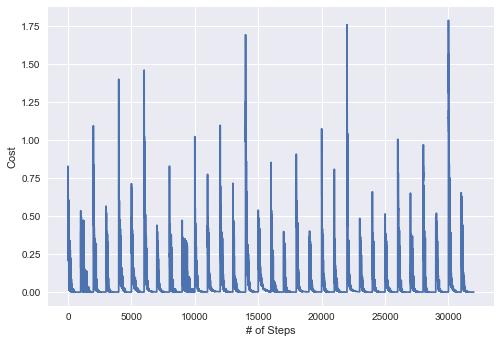

In [51]:
plt.style.use("seaborn")
plt.plot(cost_hist)
plt.ylabel("Cost")
plt.xlabel("# of Steps")

# We have two iterations of Basin Hopping for each data to be compressed, hence we have 32 peaks in the plot

In [44]:
print(weight_tensor)    # Contains all the trained parameters for each data to be compressed

[array([ 6.29698239e-01,  5.95433935e-05,  2.94142981e+00,  1.94915359e+00,
       -6.26978342e-04,  5.43619738e-01,  1.31629664e-01,  3.14526911e+00,
        4.87306844e-01,  1.41883461e+00, -1.47087267e-01,  1.16133472e+00,
        5.91782760e-01,  3.78129232e+00,  7.69555464e-01,  3.16302730e-01,
        2.50218196e-01, -9.07608926e-01,  1.02118466e+00,  3.51747015e+00,
        1.18153617e+00,  3.21249648e+00,  2.26473572e+00,  2.66165708e+00,
        1.34535197e+00,  2.41201914e+00,  9.49820878e-01,  1.97104369e+00,
        2.90055398e+00,  2.86616755e+00,  2.58760336e+00,  1.02956404e-01,
        1.04066642e+00, -1.96806520e-01, -3.30858639e-02,  1.14297708e+00,
        1.98061090e+00, -1.47147530e-01,  2.59179027e+00,  1.88242598e+00,
        2.44469343e+00,  3.32605674e+00, -7.95765063e-01,  2.92667136e+00,
        3.35341557e+00, -1.25592505e+00, -4.60663841e-02, -2.41973930e-02,
        2.11468749e+00,  1.03397543e-01,  8.36909785e-01,  1.91932964e+00,
       -3.30883726e-02, 

In [55]:
# Compress entire dataset
for i in range(len(data)):
    for j in range(2):
        anci_0, anci_1, compressed_1, compressed_2 = circuit(weight_tensor[i], data[i])
    print('Data: ', data[i],' is compressed to ', '[''%.2f'%compressed_1,',', '%.2f'%compressed_2,']' ', Ancilla qubits: ', anci_0, anci_1)
    # Ancilla quibt values represent accuracy of compression. For perfect compression, each ancilla qubit should be equal to 1

Data:  [0 0 0 0]  is compressed to  [-0.88 , 0.59 ], Ancilla qubits:  0.9999994040961079 0.9999982843683499
Data:  [1 0 0 0]  is compressed to  [-0.92 , 0.64 ], Ancilla qubits:  0.9998016699560611 0.9996420869026843
Data:  [0 1 0 0]  is compressed to  [0.10 , 0.41 ], Ancilla qubits:  0.9998389809180755 0.9997610181431456
Data:  [1 1 0 0]  is compressed to  [0.12 , 0.98 ], Ancilla qubits:  0.9998361470978652 0.9996625532231848
Data:  [0 0 1 0]  is compressed to  [0.92 , 0.77 ], Ancilla qubits:  0.9999406793334826 0.9998973104139963
Data:  [1 0 1 0]  is compressed to  [-0.89 , 0.84 ], Ancilla qubits:  0.9996847822944774 0.9992840506874552
Data:  [0 1 1 0]  is compressed to  [-0.73 , 0.71 ], Ancilla qubits:  0.999996553546788 0.9997859895228567
Data:  [1 1 1 0]  is compressed to  [0.17 , 0.76 ], Ancilla qubits:  0.9994150350776454 0.9993959043312183
Data:  [0 0 0 1]  is compressed to  [0.91 , 0.91 ], Ancilla qubits:  0.9997784333461313 0.9997916442405745
Data:  [1 0 0 1]  is compressed to